# EWC

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 20
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = f"class_saturation/{N_EXPERIENCES}"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/ewc.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

In [8]:
best_hyperparameters = {
    'ewc_lambda': 50.0
}

## Evaluation metrics definition

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [10]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [11]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = EWC(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/20 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 116.12it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 129.0000
	Loss_MB/train_phase/train_stream/Task000 = 1.2563
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 4.0392
100%|██████████| 469/469 [00:03<00:00, 118.27it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 118.6000
	Loss_MB/train_phase/train_stream/Task000 = 0.7344
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.9655
100%|██████████| 469/469 [00:04<00:00, 116.96it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 141.5000
	Loss_MB/train_phase/train_stream/Task000 = 0.5014
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0101
100%|██████████| 469/469 [00:03<00:00, 118.88it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

  5%|▌         | 1/20 [00:40<12:45, 40.27s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.5073
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x165383880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

 10%|█         | 2/20 [01:21<12:12, 40.71s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.2195
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16ad8bf70>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

 15%|█▌        | 3/20 [02:03<11:40, 41.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.9075
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16c35c0d0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

 20%|██        | 4/20 [02:46<11:14, 42.14s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.0950
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16c402070>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 25%|██▌       | 5/20 [03:32<10:51, 43.41s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.9174
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x176d2ef10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 30%|███       | 6/20 [04:18<10:20, 44.35s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.0292
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x177502820>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 35%|███▌      | 7/20 [05:04<09:41, 44.76s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.0665
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1775917f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 40%|████      | 8/20 [05:53<09:14, 46.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6515
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x29125f970>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 45%|████▌     | 9/20 [06:43<08:39, 47.26s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.9294
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x291737d90>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 50%|█████     | 10/20 [07:32<08:00, 48.00s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.9423
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x291fdcb50>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 55%|█████▌    | 11/20 [08:22<07:16, 48.50s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.9646
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2937511f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 60%|██████    | 12/20 [09:13<06:35, 49.44s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.0446
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x293b5be80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 65%|██████▌   | 13/20 [10:05<05:51, 50.22s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.0922
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x294c816a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 70%|███████   | 14/20 [11:02<05:12, 52.10s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.6816
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x295a418e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 75%|███████▌  | 15/20 [11:59<04:28, 53.60s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.2289
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x296913040>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 80%|████████  | 16/20 [12:57<03:39, 54.87s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.7180
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x297031880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 85%|████████▌ | 17/20 [13:57<02:49, 56.58s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.2943
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2973f9c10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 90%|█████████ | 18/20 [14:56<01:54, 57.32s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 108.1042
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2984cb640>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

 95%|█████████▌| 19/20 [15:56<00:57, 57.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 107.8293
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x29947c730>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

100%|██████████| 20/20 [16:59<00:00, 50.99s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.9599
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x29a438a60>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2283.5820
	EvalStream/Acc_Matrix = 
tensor([[0.9117, 0.1381, 0.1097, 0.1739, 0.1316, 0.0857, 0.1520, 0.0996, 0.0973,
         0.1312, 0.0890, 0.1189, 0.1310, 0.1746, 0.0962, 0.1186, 0.1075, 0.1101,
         0.0855, 0.1474],
        [0.9010, 0.9226, 0.1241, 0.1394, 0.1446, 0.0802, 0.1191, 0.0917, 0.0995,
         0.1676, 0.1167, 0.1255, 0.1276, 0.1032, 0.1161, 0.0918, 0.0896, 0.1016,
         0.1095, 0.1299],
        [0.8979, 0.8958, 0.9258, 0.1215, 0.1064, 0.1059, 0.0815, 0.1094, 0.0898,
         0.1333, 0.1137, 0.1428, 0.1235, 0.0933, 0.1656, 0.0650, 0.0773, 0.1295,
         0.1636, 0.1138],
        [0.8794, 0.8811, 0.9035, 0.9257, 0.0818, 0.0688, 0.0981, 0.1092, 0.0819,
         0.1238, 0.0876, 0.1391, 0.1547, 0.1238, 0.1

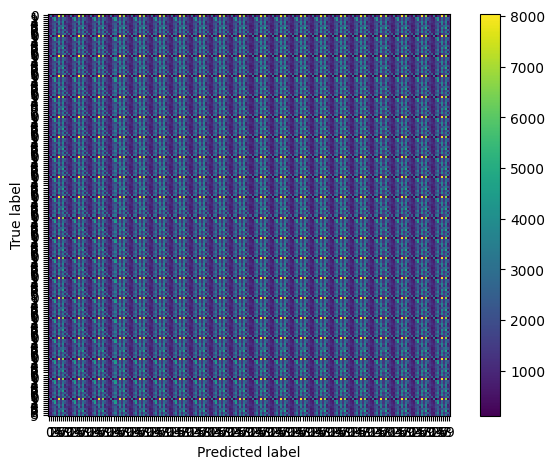

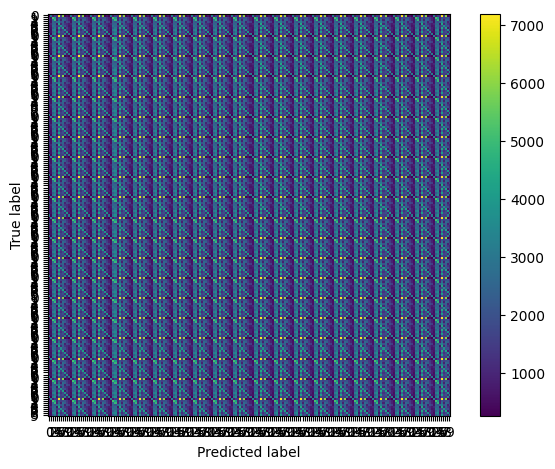

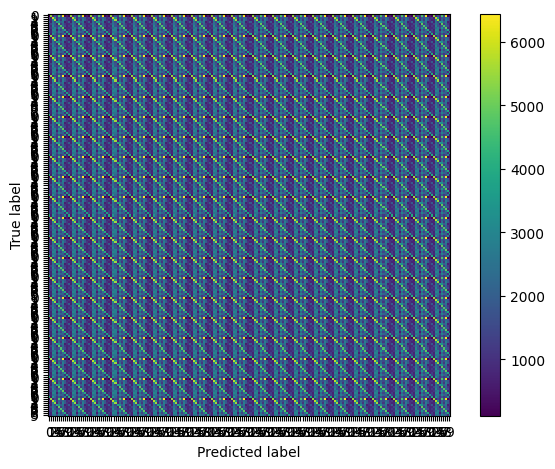

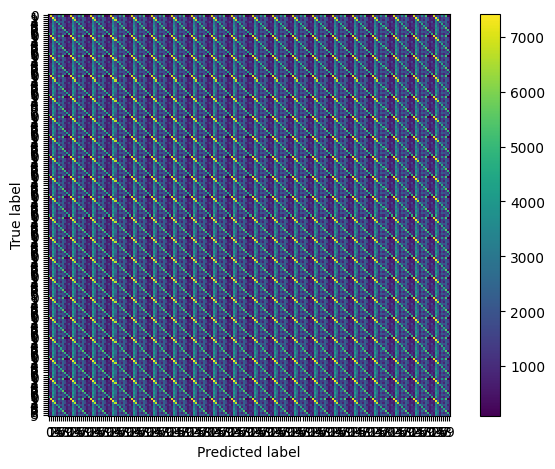

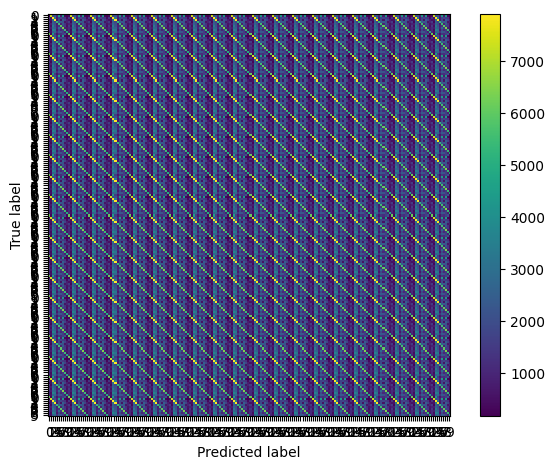

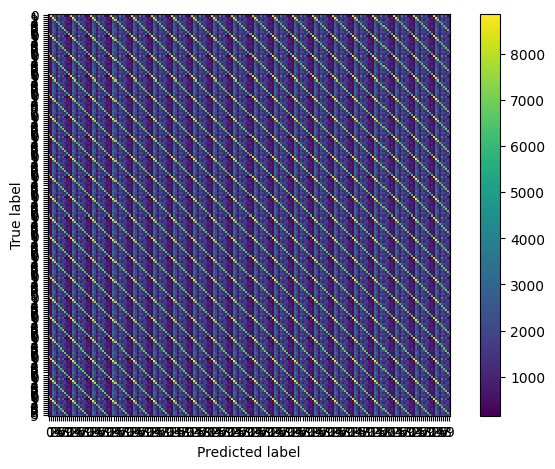

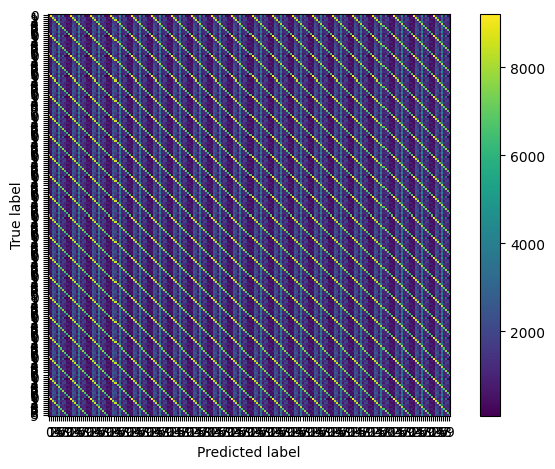

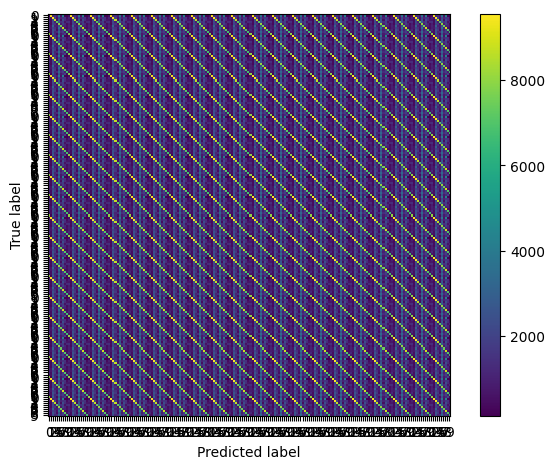

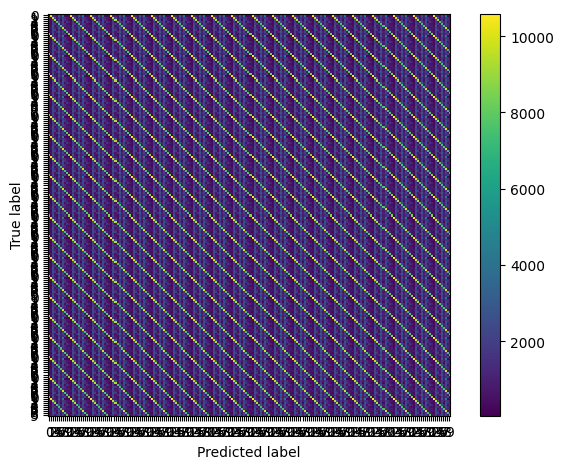

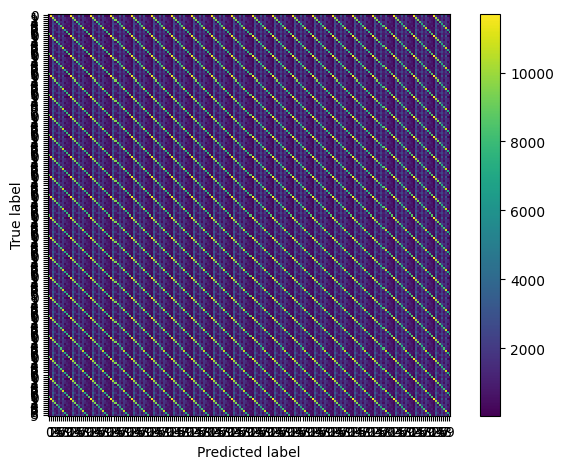

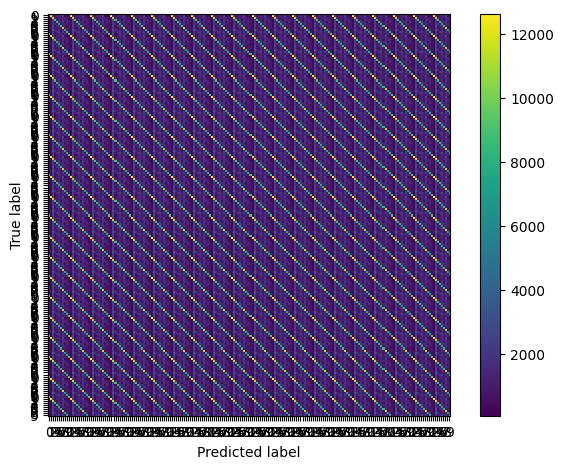

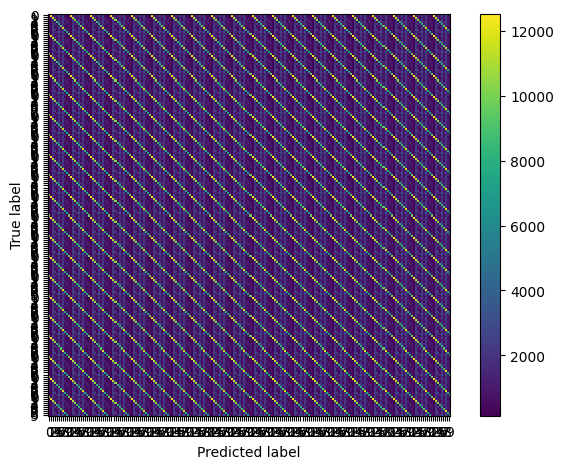

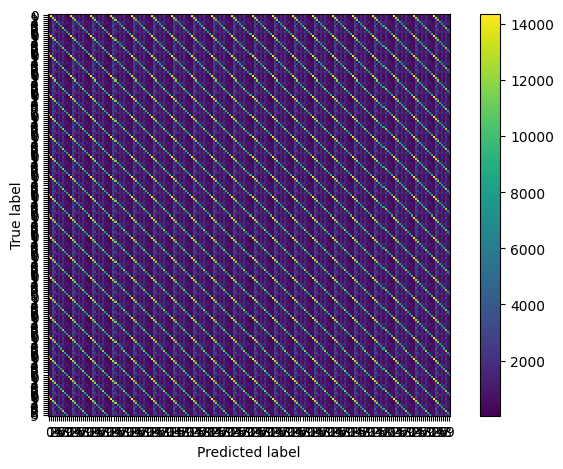

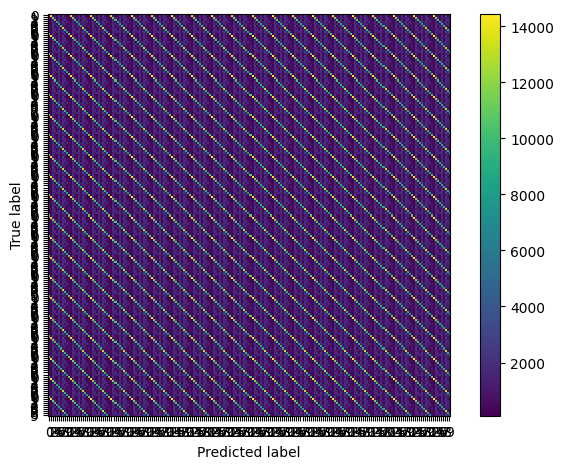

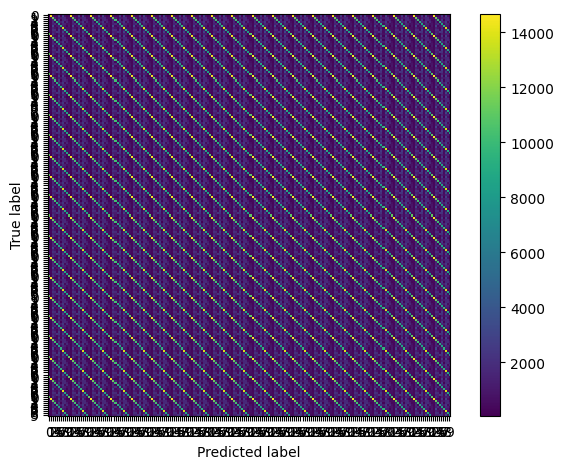

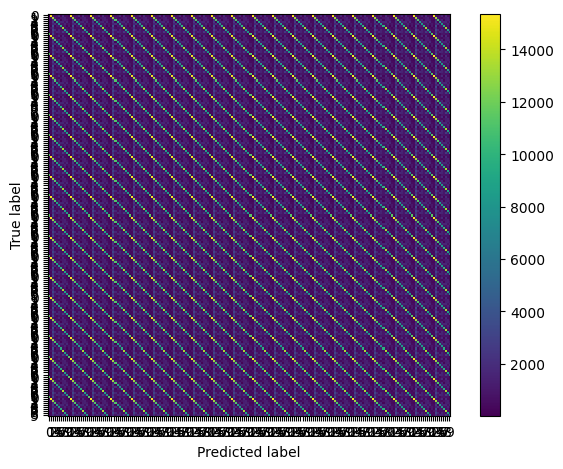

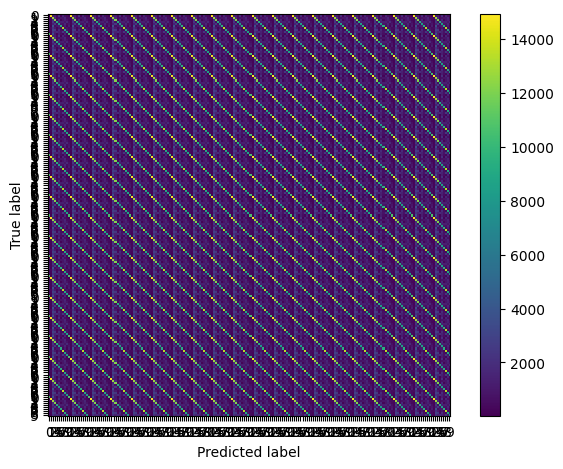

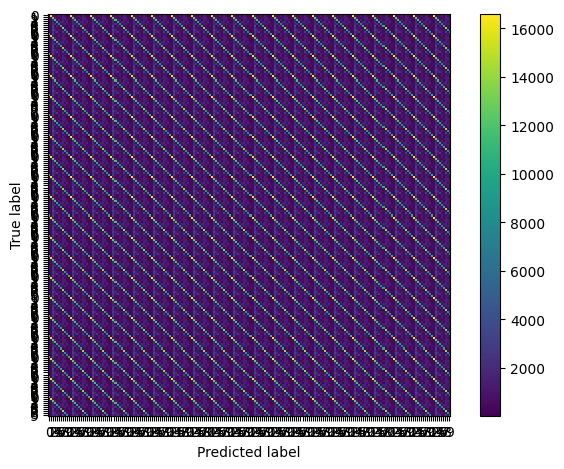

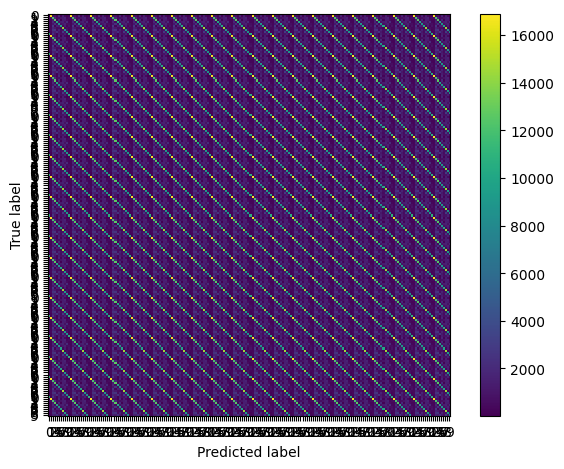

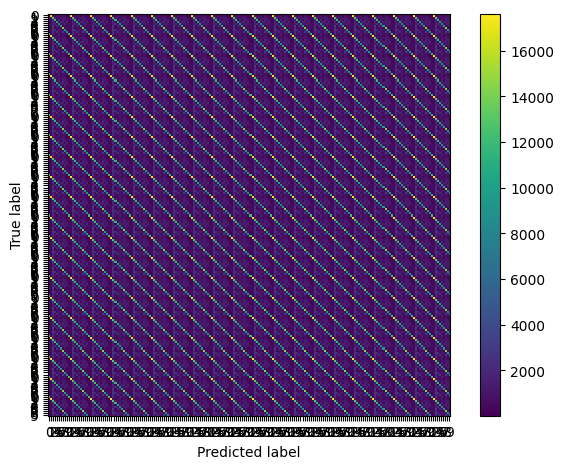

In [12]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [13]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [14]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [15]:
weights = model_plugins[0].weights

# Store metrics

In [16]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))